# Как оценивать качество решения ML-задачи?

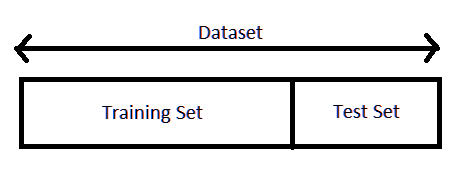

## Метрики задачи классификации

### Подготовка данных

Набор данных - [Breast Cancer Wisconsin](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic) для задачи бинарной классификации

Признаки рассчитаны по оцифрованному изображению тонкоигольной аспирационной биопсии тканей молочной железы.



In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
data = load_breast_cancer()

# 0 – "доброкачественный"
# 1 – "злокачественный"
y = 1 - data["target"]
X = data["data"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, test_size=0.25)

DummyClassifier - baseline

In [3]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train);

Логистическая регрессия - более сложная модель

In [4]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train);

C:\Libs\anaconda3\envs\ml-table\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Accuracy

Accuracy (точность) - доля объектов, для которых мы правильно предсказали класс

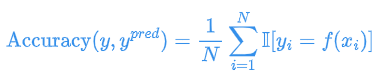

Данная метрика очень простая, но не лишена недостатков: она не учитывает дисбаланс классов.

Предположим, что мы решаем задачу классификации писем со спамом, и у нас в выборке 1000 объектов, из которых спам - 10 писем, а остальные 990 - не спам.

Тогда, взяв "модель", которая всегда классифицирует письмо как "не спам", мы автоматически получим accuracy = **0.99**, хотя сам классификатор не имеет никакой ценности.

Кроме того, иногда цена ошибки для разных классов отличается, например, в медицинской диагностике.



In [5]:
from sklearn.metrics import accuracy_score

In [6]:
y_pred_dummy = dummy_clf.predict(X_test)
accuracy_score(y_test, y_pred_dummy)

0.6293706293706294

In [7]:
y_pred_log_reg = log_reg.predict(X_test)
accuracy_score(y_test, y_pred_log_reg)

0.9790209790209791

Рассмотрим более сложные метрики, позволяющие скорректировать недостатки Accuracy

### Precision & Recall

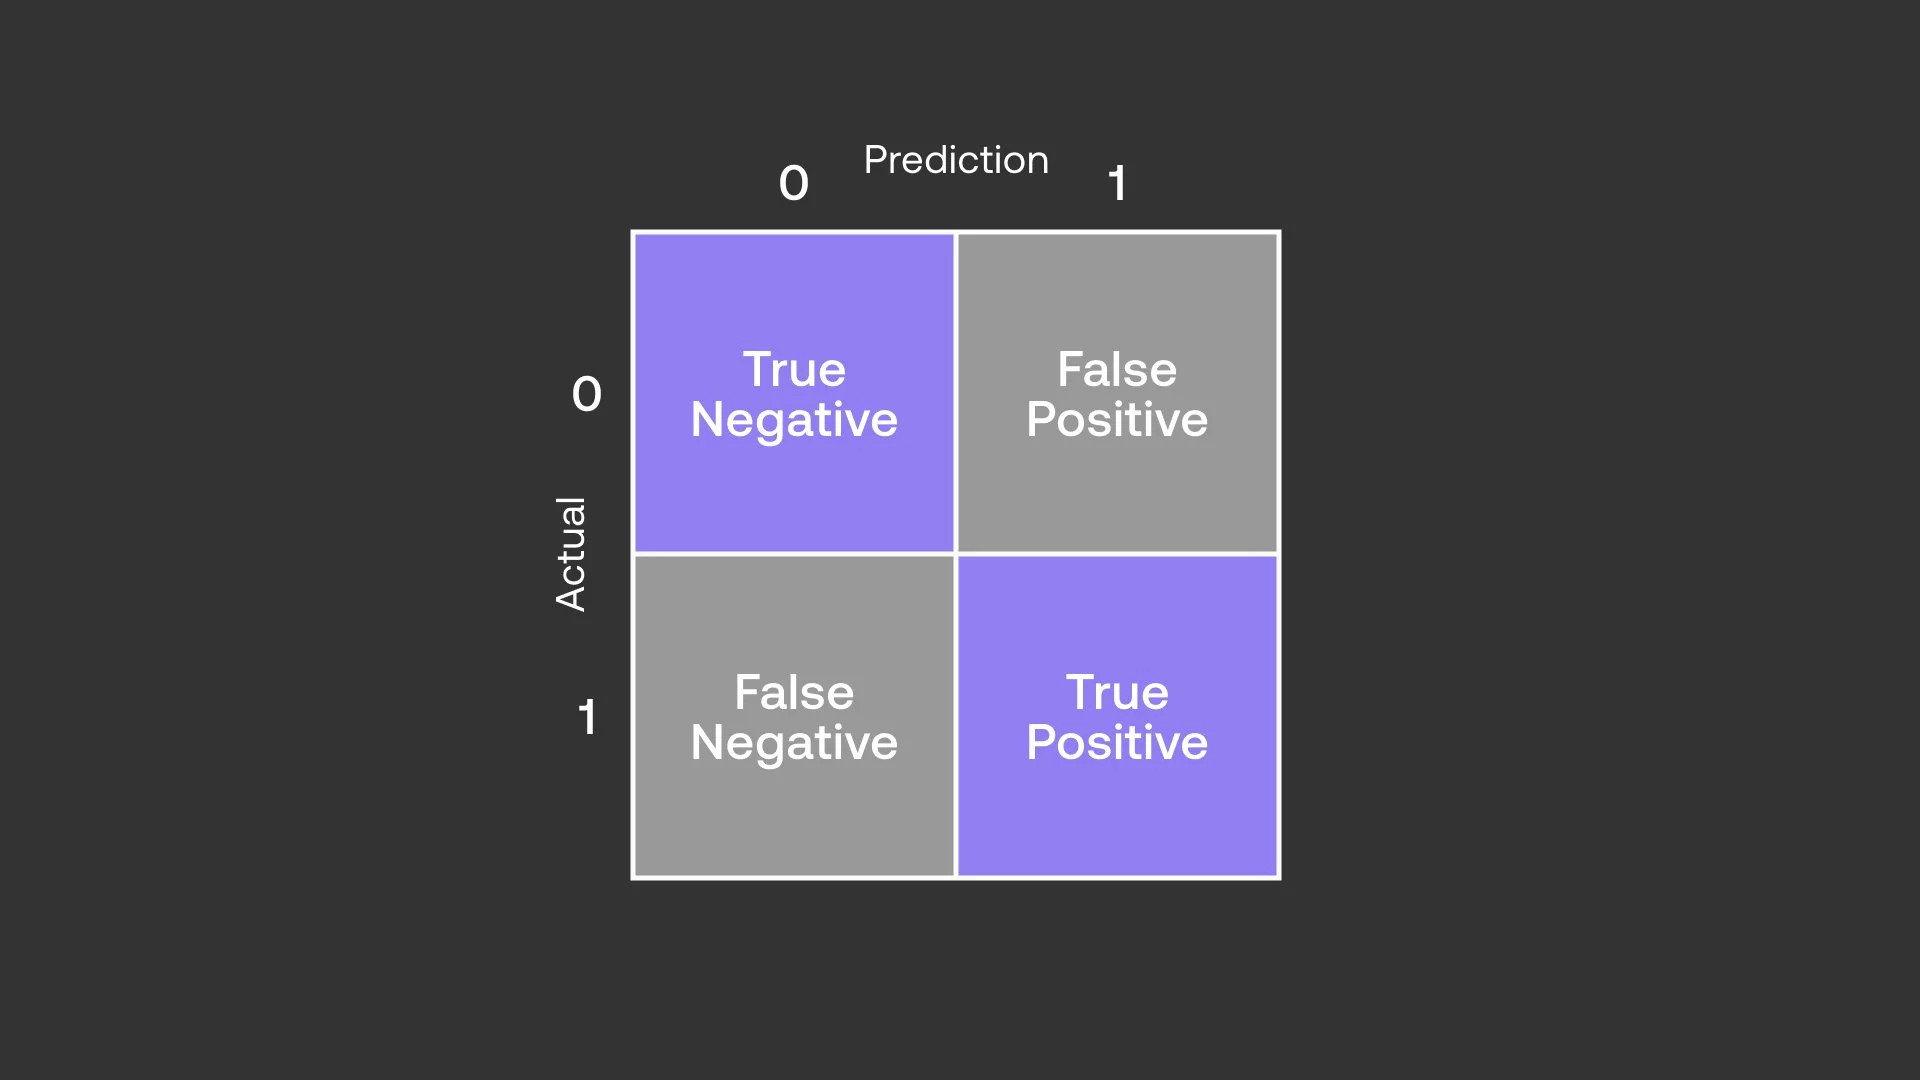

**TP** — истино-положительное решение;

**TN** — истино-отрицательное решение;

**FP** — ложно-положительное решение;

**FN** — ложно-отрицательное решение

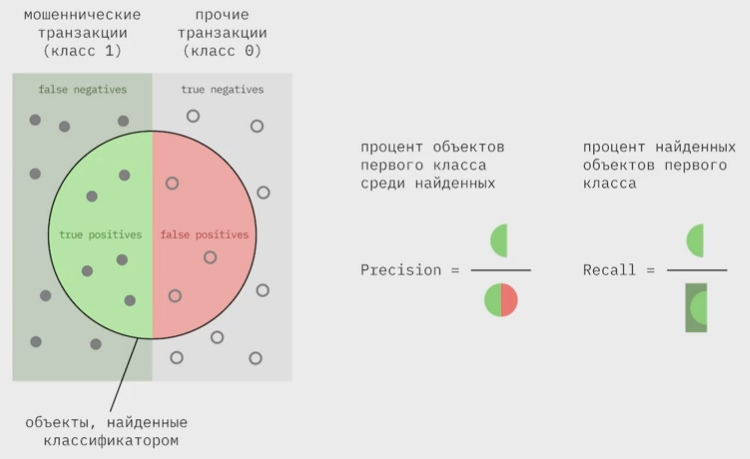

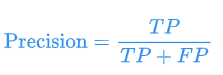

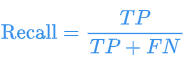

In [8]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [9]:
confusion_matrix(y_test, y_pred_dummy)

array([[90,  0],
       [53,  0]], dtype=int64)

In [10]:
confusion_matrix(y_test, y_pred_log_reg)

array([[88,  2],
       [ 1, 52]], dtype=int64)

In [11]:
print(f'Precision for Dummy Classificator: {precision_score(y_test, y_pred_dummy, zero_division=0)}')
print(f'Precision for Logistic regression: {precision_score(y_test, y_pred_log_reg, zero_division=0)}')

Precision for Dummy Classificator: 0.0
Precision for Logistic regression: 0.9629629629629629


In [12]:
print(f'Recall for Dummy Classificator: {recall_score(y_test, y_pred_dummy)}')
print(f'Recall for Logistic regression: {recall_score(y_test, y_pred_log_reg)}')

Recall for Dummy Classificator: 0.0
Recall for Logistic regression: 0.9811320754716981


### F-мера

Более удобно, когда метрика выражена одним числом. F-мера - комбинация precision и recall. Она стремится к нулю, если точность или полнота стремится к нулю.

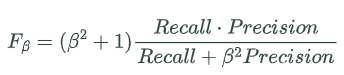

В случае, когда `beta = 1` precision и recall имеют одинаковый вклад в метрику. При `0 < beta < 1` больший вклад имеет precision, при `beta > 1` - recall

In [13]:
from sklearn.metrics import f1_score, fbeta_score

In [14]:
print(f'F1-score for Dummy Classificator: {f1_score(y_test, y_pred_dummy)}')
print(f'F1-score for Logistic regression: {f1_score(y_test, y_pred_log_reg)}')

F1-score for Dummy Classificator: 0.0
F1-score for Logistic regression: 0.9719626168224299


In [15]:
print(f'F1-score for Dummy Classificator (recall bias): {fbeta_score(y_test, y_pred_dummy, beta=2)}')
print(f'F1-score for Logistic regression (recall bias): {fbeta_score(y_test, y_pred_log_reg, beta=2)}')

F1-score for Dummy Classificator (recall bias): 0.0
F1-score for Logistic regression (recall bias): 0.9774436090225564


In [16]:
print(f'Fbeta-score for Dummy Classificator (precision bias): {fbeta_score(y_test, y_pred_dummy, beta=0.5)}')
print(f'Fbeta-score for Logistic regression (precision bias): {fbeta_score(y_test, y_pred_log_reg, beta=0.5)}')

Fbeta-score for Dummy Classificator (precision bias): 0.0
Fbeta-score for Logistic regression (precision bias): 0.9665427509293681


Для оптимизации метрик можно перебрать пороги бинаризации при классификации (по умолчанию порог = 0.5), для каждого значения рассчитать precision и recall, а затем построить кривые метрик и выбрать оптимальное значение

In [17]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

In [18]:
y_pred = log_reg.predict_proba(X_test)[:, 1]

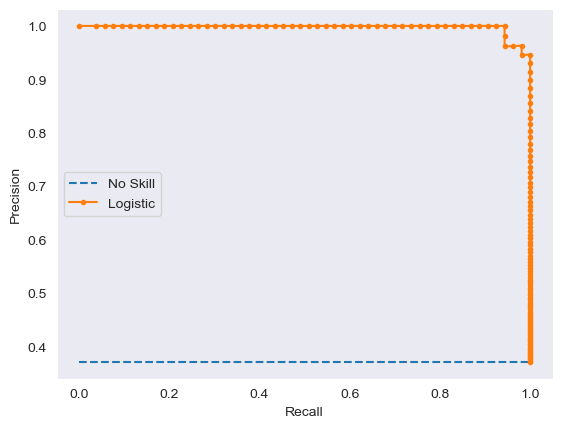

In [19]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

no_skill = len(y_test[y_test == 1]) / len(y_test)

plt.plot([0,1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

### AUC ROC – площадь под ROC-кривой

Показывает долю ложно положительных примеров (false positive rate) в сравнении с долей истинно положительных примеров (англ. true positive rate).

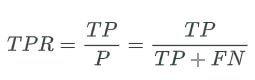

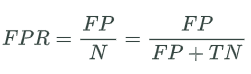

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score

In [21]:
def plot_roc_auc(fpr, tpr, thresholds, title):
  plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
  plt.plot(fpr, tpr, marker='.', label='Logistic')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.grid()
  plt.show()

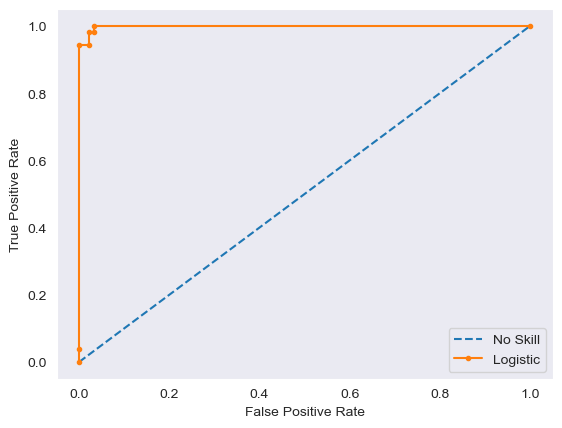

In [22]:
y_pred = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plot_roc_auc(fpr, tpr, thresholds, title='Logistic regression')

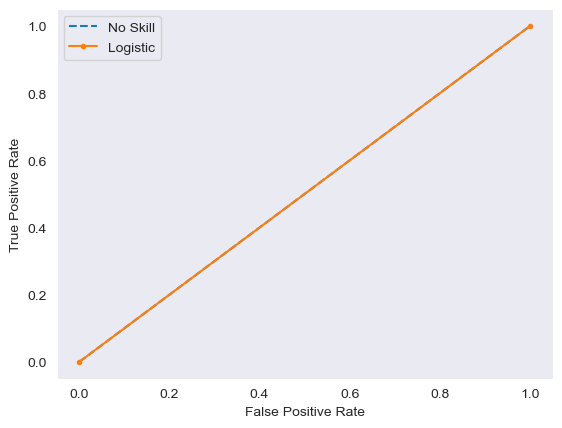

In [23]:
y_pred = dummy_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plot_roc_auc(fpr, tpr, thresholds, title='Dummy')

Чем лучше классификатор разделяет два класса, тем больше площадь (area under curve) под ROC-кривой – и мы можем использовать её в качестве метрики.

### Многоклассовая классификация - F1-мера

Если классов больше, чем 2, мы имеем дело с многоклассовой классификацией.

Если задача классификации на  классов ставится как  задач об отделении каждого класса  от остальных (one vs all), то для каждой из них можно посчитать свою матрицу ошибок. Затем есть два варианта получения итогового значения метрики из  матриц ошибок:

- **micro**: усредняем элементы матрицы ошибок (TP, FP, TN, FN) между бинарными классификаторами, например . Затем по одной усреднённой матрице ошибок считаем Precision, Recall, F-меру.

- **macro**: считаем Precision, Recall для каждого классификатора отдельно, а потом усредняем.

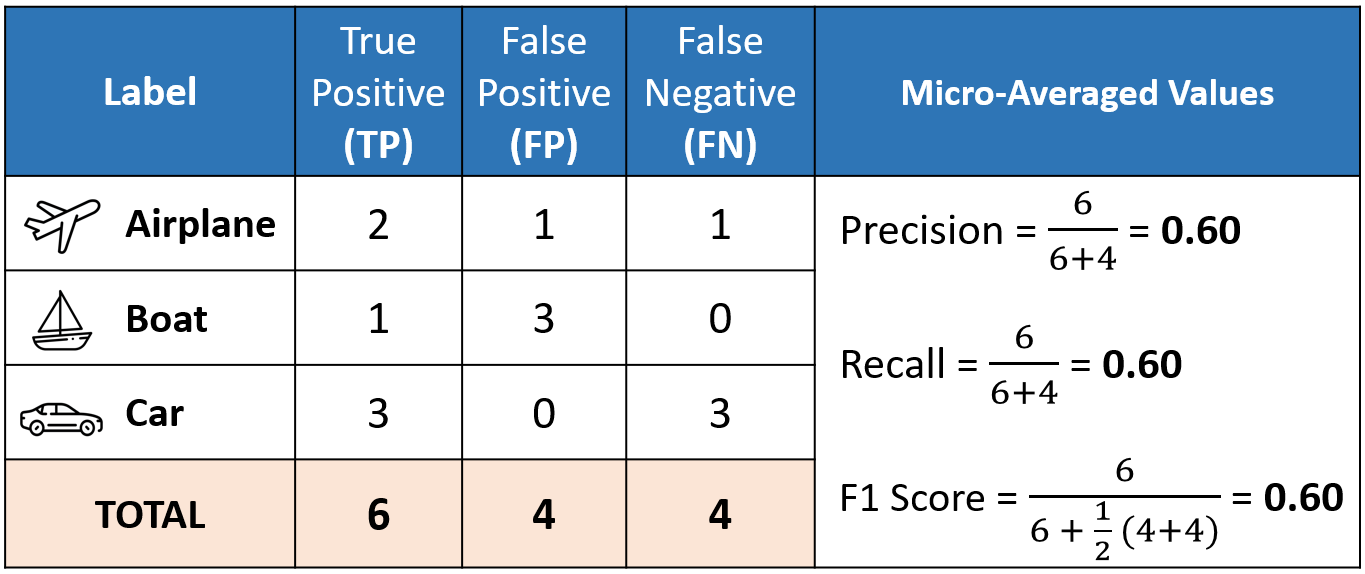

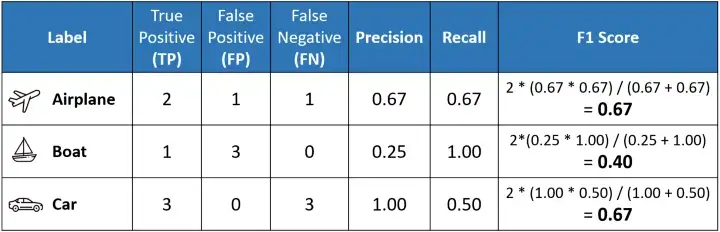

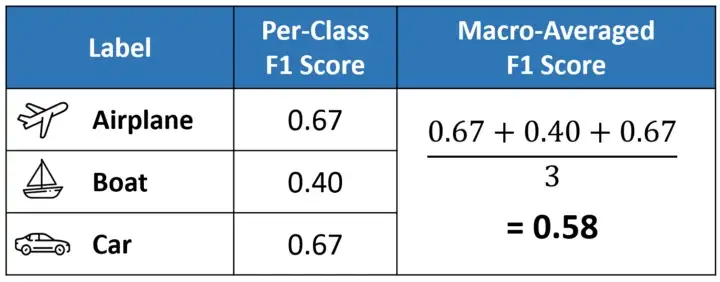

В случае дисбаланса классов способ усреднения может оказать существенное влияние: при макроусреднении все классы вносят одинаковый вклад, при микроусреднении минорные классы не влияют на метрику

## Метрики задачи регрессии

### Подготовка данных

Набор данных содержит данные о пациентах с диабетом и содержит определенные характеристики, такие как их ИМТ, возраст, артериальное давление и уровень глюкозы, которые полезны для прогнозирования прогрессирования диабета у пациентов.

In [24]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

In [25]:
X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, test_size=0.25)
X_train.head()

age       sex       bmi        bp        s1        s2        s3  \
422 -0.078165  0.050680  0.077863  0.052858  0.078236  0.064447  0.026550   
409 -0.052738  0.050680 -0.011595  0.056301  0.056221  0.072902 -0.039719   
55  -0.041840 -0.044642 -0.049318 -0.036656 -0.007073 -0.022608  0.085456   
157 -0.001882  0.050680 -0.033151 -0.018306  0.031454  0.042840 -0.013948   
70  -0.001882 -0.044642 -0.069797 -0.012556 -0.000193 -0.009143  0.070730   

           s4        s5        s6  
422 -0.002592  0.040673 -0.009362  
409  0.071210  0.030564 -0.005220  
55  -0.039493 -0.066490  0.007207  
157  0.019917  0.010227  0.027917  
70  -0.039493 -0.062917  0.040343

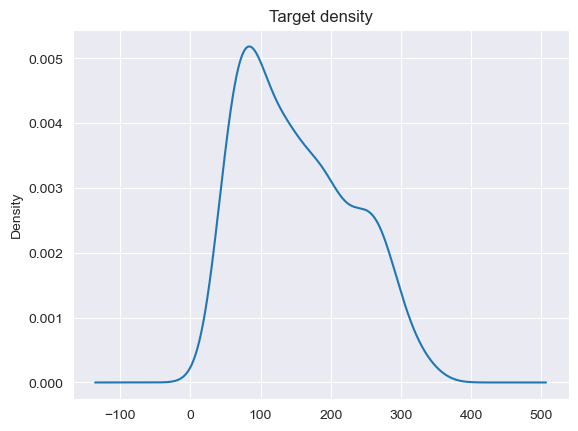

In [26]:
y.plot(kind='kde', title='Target density');

In [27]:
dummy = DummyRegressor(strategy='median')
dummy.fit(X_train, y_train)
y_preds_dummy = dummy.predict(X_test)

In [28]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds_lr = lr.predict(X_test)

### MSE & RMSE

MSE – одна из самых популярных метрик в задаче регрессии.

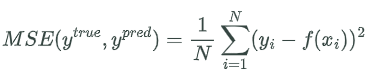

In [29]:
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pandas as pd

In [30]:
print(f'MSE for Dummy Regressor: {mean_squared_error(y_test, y_preds_dummy)}')
print(f'MSE for Linear regression: {mean_squared_error(y_test, y_preds_lr)}')

MSE for Dummy Regressor: 6667.117117117117
MSE for Linear regression: 3220.1288682415798


In [31]:
print(f'RMSE for Dummy Regressor: {mean_squared_error(y_test, y_preds_dummy, squared=False)}')
print(f'RMSE for Linear regression: {mean_squared_error(y_test, y_preds_lr, squared=False)}')

RMSE for Dummy Regressor: 81.65241648057403
RMSE for Linear regression: 56.74617932726026


In [32]:
def plot_model_results(actual, predicted, title):
  results = pd.DataFrame({'True': actual, 'Prediction': predicted})
  sns.lmplot(x='True', y='Prediction', data=results, fit_reg=False)
  d_line= np.arange(results.min().min(), results.max().max())
  plt.plot(d_line, d_line, color='red', linestyle='--')
  plt.title = title
  plt.grid()
  plt.show()

C:\Libs\anaconda3\envs\ml-table\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


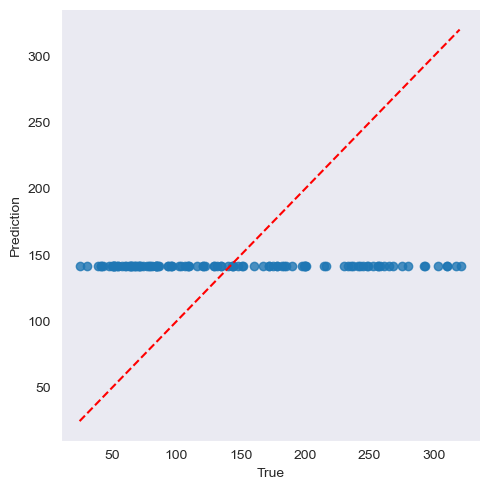

In [33]:
plot_model_results(y_test, y_preds_dummy, title='Dummy')

C:\Libs\anaconda3\envs\ml-table\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


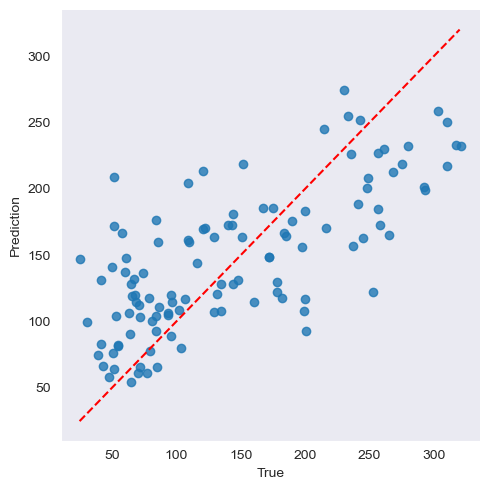

In [34]:
plot_model_results(y_test, y_preds_lr, title='Linear Regression')

MSE квадратично штрафует за большие ошибки на объектах. Сильный штраф за ошибки - полезное свойство, но если тестовых данных присутствуют выбросы, то нам будет сложно объективно сравнить модели между собой: ошибки на выбросах будет маскировать различия в ошибках на основном множестве объектов.

Таким образом, если мы будем сравнивать две модели при помощи MSE, у нас будет выигрывать та модель, у которой меньше ошибка на объектах-выбросах

RMSE - квадратный корень из MSE. Рассчитывается в тех же единицах, что и целевая переменная

### MAE

Для уменьшения чувствительности к выбросам можно использовать MSE

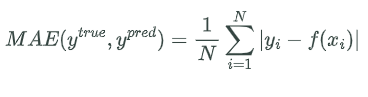

In [35]:
from sklearn.metrics import mean_absolute_error

In [36]:
print(f'MAE for Dummy Regressor: {mean_absolute_error(y_test, y_preds_dummy)}')
print(f'MAE for Linear regression: {mean_absolute_error(y_test, y_preds_lr)}')

MAE for Dummy Regressor: 70.28828828828829
MAE for Linear regression: 46.363777674625645


### MAPE

MSE и MAE считают абсолютную ошибку, однако бывает полезно посчитать относительную, например, в процентах

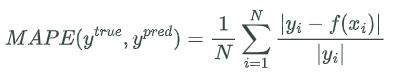

In [37]:
from sklearn.metrics import mean_absolute_percentage_error

In [38]:
print(f'MAPE for Dummy Regressor: {mean_absolute_percentage_error(y_test, y_preds_dummy)}')
print(f'MAPE for Linear regression: {mean_absolute_percentage_error(y_test, y_preds_lr)}')

MAPE for Dummy Regressor: 0.7267639652835988
MAPE for Linear regression: 0.489266958064738


### Коэффициент детерминации

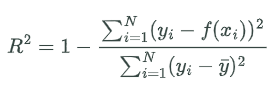

Коэффициент детерминации показывает, какая доля дисперсии таргетов (знаменатель) объяснена моделью. У идеальных предсказаний равен 1, у лучшего константного предсказания он равен  0 на обучающей выборке.

In [39]:
from sklearn.metrics import r2_score

In [40]:
print(f'R2 score for Dummy Regressor: {r2_score(y_test, y_preds_dummy)}')
print(f'R2 score for Linear regression: {r2_score(y_test, y_preds_lr)}')

R2 score for Dummy Regressor: -0.00028879043300489293
R2 score for Linear regression: 0.5168738220629059


Основная проблема применения этой метрики заключается в том, что ее значение увеличивается (не уменьшается) от добавления в модель новых переменных, даже если эти переменные никакого отношения к объясняемой переменной не имеют. Поэтому сравнение моделей с разным количеством факторов с помощью коэффициента детерминации, вообще говоря, некорректно. Для этих целей можно использовать альтернативные показатели (adjusted R squared).

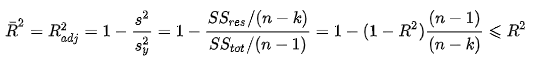

 n — количество наблюдений, k — количество параметров

В целом лучший способ добиться минимизации метрики  — выбрать ее в качестве функции потерь. MSE, RMSE можно оптимизировать напрямую, MAE - тоже, но доопределив в точке 0.

## Кросс-валидация

Процесс обучения модели можно представить в следующем виде:

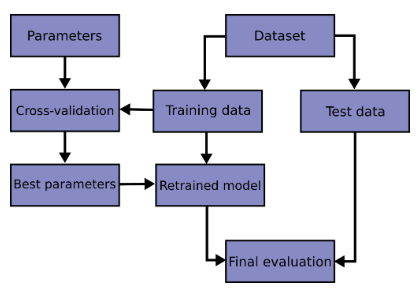

При обучении модели мы измеряем качество на тестовых данных, однако подбор моделей / гиперпараметров стоит проводить на валидационном наборе данных, а уже после финально оценивать качество на тесте.

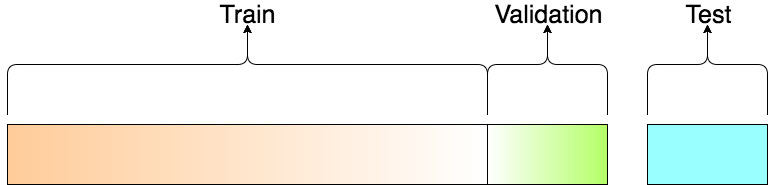

In [41]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

y = 1 - y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, test_size=0.15, stratify=y) # разбиение со стратификацией

#### K-Fold


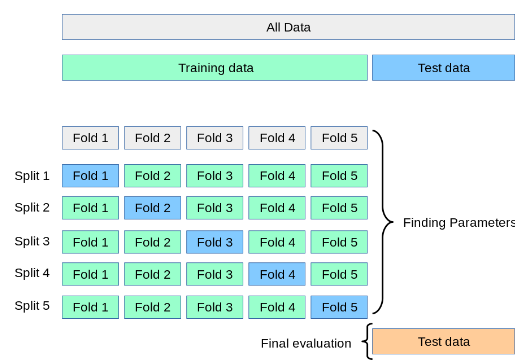

In [42]:
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

log_reg = LogisticRegression()
cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='f1')

array([1.        , 0.92957746, 0.98591549, 1.        , 0.91176471])

Альтернатива

In [44]:
kf = KFold(n_splits=5)
for _, (train_index, val_index) in enumerate(kf.split(X_train_scaled)):
  train_data, train_label = X_train_scaled[train_index], y_train.iloc[train_index]
  val_data, val_label = X_train_scaled[val_index], y_train.iloc[val_index]

  log_reg = LogisticRegression()
  log_reg.fit(train_data, train_label)
  y_pred = log_reg.predict(val_data)
  print(f1_score(val_label, y_pred), end=', ')

1.0, 0.9210526315789475, 0.9841269841269841, 1.0, 0.9032258064516129, 

In [45]:
skf = StratifiedKFold(n_splits=5)
for _, (train_index, val_index) in enumerate(skf.split(X_train_scaled, y_train)):
  train_data, train_label = X_train_scaled[train_index], y_train.iloc[train_index]
  val_data, val_label = X_train_scaled[val_index], y_train.iloc[val_index]

  log_reg = LogisticRegression()
  log_reg.fit(train_data, train_label)
  y_pred = log_reg.predict(val_data)
  print(f1_score(val_label, y_pred), end=', ')

1.0, 0.9295774647887323, 0.9859154929577464, 1.0, 0.911764705882353, 

Метод k-Fold даёт более надёжную оценку качества модели, чем hold-out, так как обучение и тест модели происходят на разных подмножествах исходного датасета.

### Leave-one-out

Метод leave-one-out является частным случаем метода k-Fold: в нём каждый фолд состоит ровно из одного семпла.

In [46]:
from sklearn.model_selection import LeaveOneOut

In [47]:
loo = LeaveOneOut()
for i, (train_index, val_index) in enumerate(loo.split(X_train_scaled)):
  train_data, train_label = X_train_scaled[train_index], y_train.iloc[train_index]
  val_data, val_label = X_train_scaled[val_index], y_train.iloc[val_index]

  log_reg = LogisticRegression()
  log_reg.fit(train_data, train_label)
  y_pred = log_reg.predict(val_data)
  if i % 100 == 0:
    print(f'F1-score on fold {i}: {f1_score(val_label, y_pred, zero_division=0)}')

F1-score on fold 0: 0.0
F1-score on fold 100: 0.0
F1-score on fold 200: 1.0
F1-score on fold 300: 0.0
F1-score on fold 400: 1.0


Метод может быть полезен, если очень мало данных

### Time series cross-validation

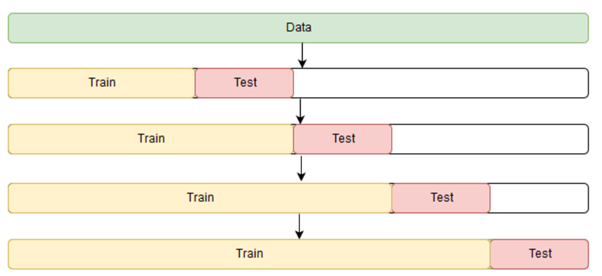

In [48]:
from sklearn.model_selection import TimeSeriesSplit

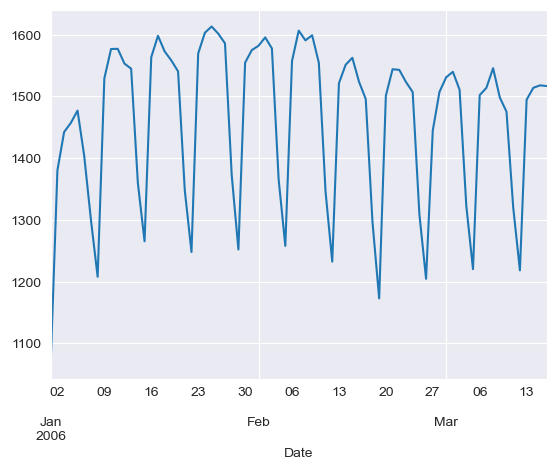

In [49]:
url = 'https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
data = pd.read_csv(url, sep=",")
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data['Consumption'].iloc[:75].plot();

In [50]:
tscv = TimeSeriesSplit(n_splits=3)

for train_index, test_index in tscv.split(data):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_data = data.iloc[train_index]

TRAIN: [   0    1    2 ... 1095 1096 1097] TEST: [1098 1099 1100 ... 2190 2191 2192]
TRAIN: [   0    1    2 ... 2190 2191 2192] TEST: [2193 2194 2195 ... 3285 3286 3287]
TRAIN: [   0    1    2 ... 3285 3286 3287] TEST: [3288 3289 3290 ... 4380 4381 4382]
